In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [5]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [6]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [7]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

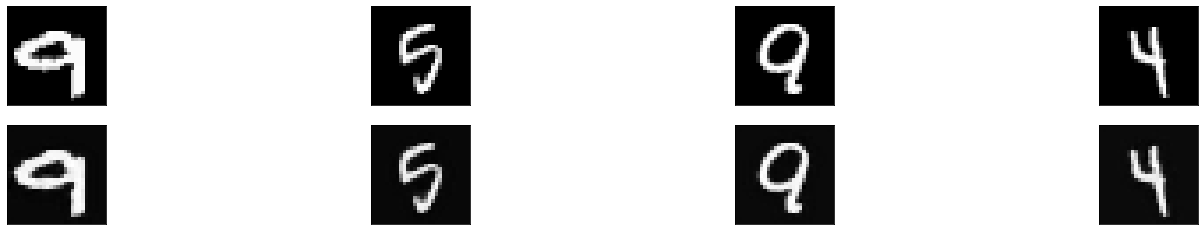

In [8]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images + .5)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [23]:
kappa = 10
gamma = 100
beta = 0.1
lr = 0.1
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=1000, n_searches=9, kappa=kappa, gamma=gamma, beta=beta, learning_rate=lr)

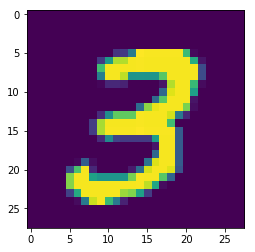

In [24]:
# obtain one sample
image = dataset.get_sample_by_class(class_label=3, show_image=False)

plt.imshow(image.squeeze())

In [25]:
# find pertinent negatives
mode = "PN"
CEM.fista(image, mode=mode)

search:0 iteration:0 lr:0.10 c value:10.00 loss: 4334.97 delta sum:0.00 optimum:False y grad:10038.592
search:0 iteration:20 lr:0.10 c value:10.00 loss: 22243.89 delta sum:-49.94 optimum:False y grad:10346.636
search:0 iteration:40 lr:0.10 c value:10.00 loss: 22910.01 delta sum:-56.50 optimum:False y grad:10797.384
search:0 iteration:60 lr:0.10 c value:10.00 loss: 24444.90 delta sum:-54.45 optimum:False y grad:10619.767
search:0 iteration:80 lr:0.10 c value:10.00 loss: 23826.97 delta sum:-55.14 optimum:False y grad:9488.350
search:0 iteration:100 lr:0.09 c value:10.00 loss: 23842.30 delta sum:-47.09 optimum:False y grad:8301.973
search:0 iteration:120 lr:0.09 c value:10.00 loss: 23852.27 delta sum:-51.88 optimum:False y grad:11352.347
search:0 iteration:140 lr:0.09 c value:10.00 loss: 26412.82 delta sum:-53.46 optimum:False y grad:16317.171
search:0 iteration:160 lr:0.09 c value:10.00 loss: 25139.57 delta sum:-54.90 optimum:False y grad:7148.394
search:0 iteration:180 lr:0.09 c value:1

search:1 iteration:520 lr:0.07 c value:100.00 loss: 26264.06 delta sum:-40.56 optimum:True y grad:8941.915
search:1 iteration:540 lr:0.07 c value:100.00 loss: 26124.98 delta sum:-36.74 optimum:True y grad:13029.348
search:1 iteration:560 lr:0.07 c value:100.00 loss: 25632.41 delta sum:-52.68 optimum:True y grad:6709.715
search:1 iteration:580 lr:0.06 c value:100.00 loss: 26923.24 delta sum:-43.62 optimum:True y grad:12118.188
search:1 iteration:600 lr:0.06 c value:100.00 loss: 25429.97 delta sum:-51.93 optimum:True y grad:7403.666
search:1 iteration:620 lr:0.06 c value:100.00 loss: 25735.72 delta sum:-51.78 optimum:True y grad:8970.034
search:1 iteration:640 lr:0.06 c value:100.00 loss: 25245.44 delta sum:-40.87 optimum:True y grad:7767.910
search:1 iteration:660 lr:0.06 c value:100.00 loss: 21491.46 delta sum:-64.22 optimum:True y grad:12832.036
search:1 iteration:680 lr:0.06 c value:100.00 loss: 21219.24 delta sum:-52.47 optimum:True y grad:3754.917
NEW BEST: 18946.841796875 - C: 100

search:3 iteration:0 lr:0.10 c value:500.50 loss: 9164.49 delta sum:0.00 optimum:False y grad:10037.638
NEW BEST: 7731.60791015625 - C: 500.5
search:3 iteration:20 lr:0.10 c value:500.50 loss: 16455.90 delta sum:-30.55 optimum:True y grad:-17195.430
search:3 iteration:40 lr:0.10 c value:500.50 loss: 15196.12 delta sum:-61.84 optimum:True y grad:7774.953
search:3 iteration:60 lr:0.10 c value:500.50 loss: 44388.10 delta sum:-61.89 optimum:True y grad:24007.428
search:3 iteration:80 lr:0.10 c value:500.50 loss: 49291.78 delta sum:-55.59 optimum:True y grad:27307.475
search:3 iteration:100 lr:0.09 c value:500.50 loss: 48390.79 delta sum:-58.36 optimum:True y grad:30235.070
search:3 iteration:120 lr:0.09 c value:500.50 loss: 46488.70 delta sum:-56.44 optimum:True y grad:35158.469
search:3 iteration:140 lr:0.09 c value:500.50 loss: 48749.76 delta sum:-48.10 optimum:True y grad:34279.148
search:3 iteration:160 lr:0.09 c value:500.50 loss: 27165.50 delta sum:-37.37 optimum:True y grad:30693.66

search:4 iteration:500 lr:0.07 c value:250.30 loss: 22887.56 delta sum:-40.59 optimum:True y grad:5913.703
search:4 iteration:520 lr:0.07 c value:250.30 loss: 25800.91 delta sum:-41.89 optimum:True y grad:7095.900
search:4 iteration:540 lr:0.07 c value:250.30 loss: 20526.31 delta sum:-57.66 optimum:True y grad:-1434.859
search:4 iteration:560 lr:0.07 c value:250.30 loss: 18473.73 delta sum:-39.95 optimum:True y grad:-3659.435
search:4 iteration:580 lr:0.06 c value:250.30 loss: 17200.26 delta sum:-62.51 optimum:True y grad:12003.532
search:4 iteration:600 lr:0.06 c value:250.30 loss: 21295.18 delta sum:-49.75 optimum:True y grad:6810.597
search:4 iteration:620 lr:0.06 c value:250.30 loss: 19424.42 delta sum:-58.69 optimum:True y grad:-6439.750
search:4 iteration:640 lr:0.06 c value:250.30 loss: 18165.76 delta sum:-70.48 optimum:True y grad:7904.626
search:4 iteration:660 lr:0.06 c value:250.30 loss: 19059.06 delta sum:-58.87 optimum:True y grad:7178.040
search:4 iteration:680 lr:0.06 c 

search:6 iteration:20 lr:0.10 c value:62.65 loss: 22602.04 delta sum:-48.46 optimum:False y grad:7564.504
search:6 iteration:40 lr:0.10 c value:62.65 loss: 22548.63 delta sum:-55.20 optimum:False y grad:7080.924
search:6 iteration:60 lr:0.10 c value:62.65 loss: 23979.17 delta sum:-53.73 optimum:False y grad:6861.219
search:6 iteration:80 lr:0.10 c value:62.65 loss: 24912.39 delta sum:-51.67 optimum:False y grad:11699.819
search:6 iteration:100 lr:0.09 c value:62.65 loss: 24328.52 delta sum:-52.44 optimum:False y grad:6611.647
search:6 iteration:120 lr:0.09 c value:62.65 loss: 24292.19 delta sum:-56.07 optimum:False y grad:7986.521
search:6 iteration:140 lr:0.09 c value:62.65 loss: 23744.29 delta sum:-47.14 optimum:False y grad:6260.195
search:6 iteration:160 lr:0.09 c value:62.65 loss: 25375.34 delta sum:-53.61 optimum:False y grad:10810.063
search:6 iteration:180 lr:0.09 c value:62.65 loss: 24260.05 delta sum:-58.10 optimum:False y grad:9230.512
search:6 iteration:200 lr:0.09 c value:

search:7 iteration:540 lr:0.07 c value:626.50 loss: 68559.46 delta sum:-49.53 optimum:True y grad:48991.242
search:7 iteration:560 lr:0.07 c value:626.50 loss: 60717.70 delta sum:-55.87 optimum:True y grad:45809.602
search:7 iteration:580 lr:0.06 c value:626.50 loss: 51652.60 delta sum:-45.58 optimum:True y grad:31971.113
search:7 iteration:600 lr:0.06 c value:626.50 loss: 59767.79 delta sum:-56.97 optimum:True y grad:38710.055
search:7 iteration:620 lr:0.06 c value:626.50 loss: 57532.36 delta sum:-60.45 optimum:True y grad:34189.469
search:7 iteration:640 lr:0.06 c value:626.50 loss: 62875.49 delta sum:-52.24 optimum:True y grad:49886.898
search:7 iteration:660 lr:0.06 c value:626.50 loss: 49664.65 delta sum:-48.57 optimum:True y grad:26264.375
search:7 iteration:680 lr:0.06 c value:626.50 loss: 48833.38 delta sum:-68.08 optimum:True y grad:28039.121
search:7 iteration:700 lr:0.05 c value:626.50 loss: 61419.46 delta sum:-51.83 optimum:True y grad:62048.387
search:7 iteration:720 lr:0.

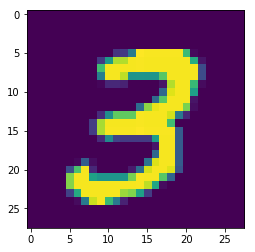

In [19]:
plt.imshow(image.squeeze())

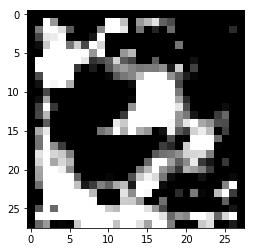

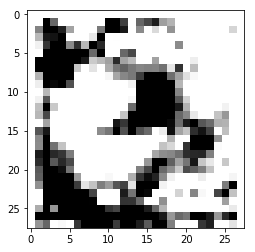

In [20]:
# perturbation
plt.imshow(image.squeeze()- CEM.best_delta.view(28,28), cmap="gray")
plt.show()
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.show()

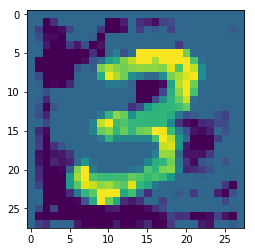

In [21]:
# original image with perturbation
plt.imshow(CEM.best_delta.view(28,28))

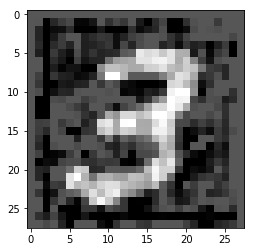

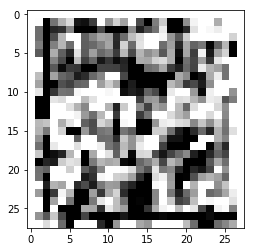

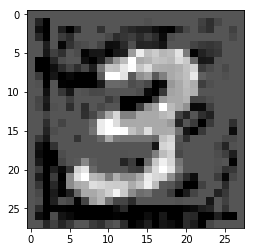

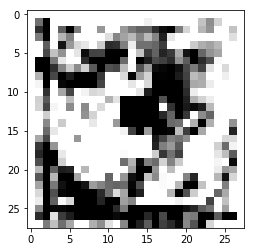

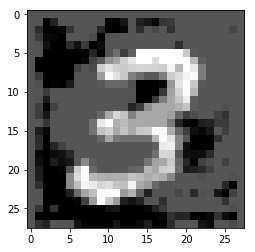

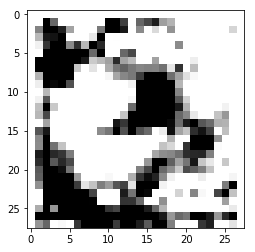

In [22]:
for d in CEM.all_best:
    plt.imshow(d.view(28,28), cmap="gray")
    plt.show()
    plt.imshow(d.view(28,28) - image.squeeze(), cmap="gray")
    plt.show()

In [82]:
# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
before

1

In [83]:
# classification after
after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
after

2

In [84]:
# classification of delta
class_delta = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
class_delta

7

In [85]:
dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")